In [1]:
import argparse
import os 
import numpy as np 
import math 
import sys 
import time 
from tqdm import tqdm

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn 
import torch.nn.functional as F 
import torch.autograd as autograd
import torch

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args(args=[])
opt 

Namespace(b1=0.5, b2=0.999, batch_size=128, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=1000, sample_interval=400)

In [3]:
img_shape = (opt.channels,opt.img_size,opt.img_size)
cuda = True if torch.cuda.is_available() else False
# Create sample and checkpoint directories
time_now = time.strftime("WGANGP_%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))
log_path = f'./log/{time_now}'
os.makedirs(log_path)
os.makedirs(f'{log_path}/image')
os.makedirs(f'{log_path}/image/image_all')

## Datasets

In [4]:
from torch.utils.data import Dataset,DataLoader
from mlxtend.data import loadlocal_mnist
import torchvision.transforms as transforms

class MNIST_Dataset(Dataset):
    def __init__(self,train_data_path,train_label_path,transforms=None):
        train_data,train_label = loadlocal_mnist(
            images_path=train_data_path,
            labels_path=train_label_path
        )
        self.train_data = train_data
        self.train_label = train_label
        self.transform = transforms
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()
        images = self.train_data[index,:].reshape((opt.img_size,opt.img_size))
        labels = self.train_label[index]
        if self.transform:
            images = self.transform(images)
        return images,labels

    def __len__(self):
        return self.train_label.shape[0]
    
train_data_path = "../../../../data/MNIST/train-images.idx3-ubyte"
train_label_path = "../../../../data/MNIST/train-labels.idx1-ubyte"
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])]
)
dataset = MNIST_Dataset(train_data_path,train_label_path,transform)
dataloader = DataLoader(dataset,batch_size=opt.batch_size,shuffle=True)


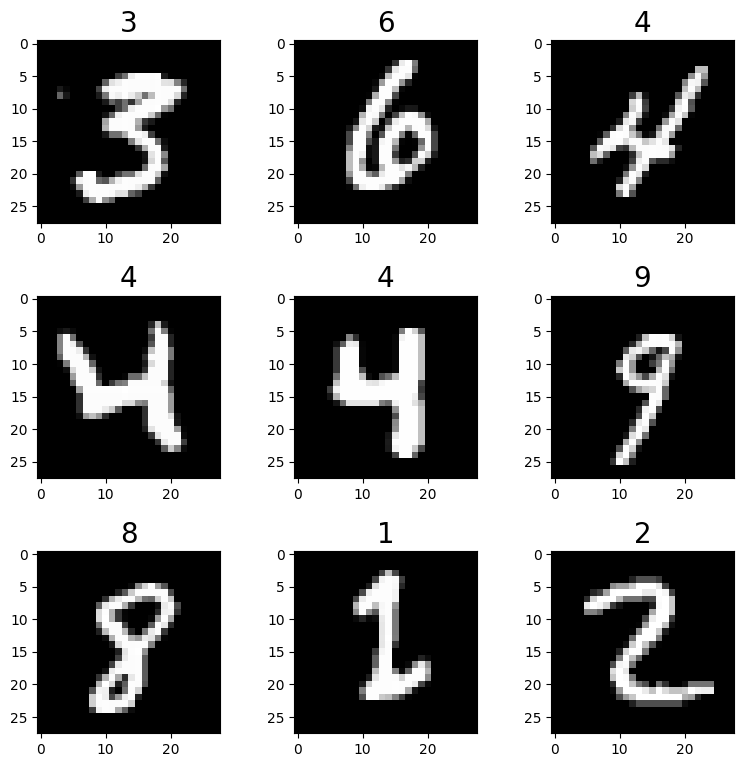

In [5]:
import matplotlib.pyplot as plt

img,ax = plt.subplots(3,3,figsize=(9,9))
plt.subplots_adjust(hspace=0.4,wspace=0.4)
for i in range(3):
    for j in range(3):
        num = np.random.randint(0,opt.batch_size)
        ax[i][j].imshow(dataset[num][0].reshape((28,28)),cmap="gray")
        ax[i][j].set_title(dataset[num][1],fontdict={"fontsize":20})
plt.show()

## Model

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        def block(in_feat,out_feat,normalize=True):
            layers = [nn.Linear(in_features=in_feat,out_features=out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,0.8))
            layers.append(nn.LeakyReLU(0.1,inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(opt.latent_dim,128,normalize=False), # *号相当于解包
            *block(128,256),
            *block(256,512),
            *block(512,1024),
            nn.Linear(1024,int(np.prod(img_shape))),
            nn.Tanh(),
        )
    
    def forward(self,z):
        img = self.model(z)
        img = img.view(img.shape[0],*img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(256,128),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Linear(128,1)
        )
        
    def forward(self,img):
        img_flat = img.view(img.shape[0],-1)
        validity = self.model(img_flat)
        return validity
    
    
    
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [15]:
# Loss weight for gradient penalty
lambda_gp = 10
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

def compute_gradient_penalty(D,real_samples,fake_samples):
    """Calculate the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0),1,1,1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha*real_samples +(1-alpha)*fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0],1).fill_(1.0),requires_grad=True)
    # Get gradient w.r.t interpolates
    gradients = autograd.grad(
        outputs= d_interpolates, # 求导的因变量
        inputs=interpolates, # 求导的自变量
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0),-1)
    gradient_penalty = ((gradients.norm(2,dim=1)-1)**2).mean()
    return gradient_penalty

In [16]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(),lr=opt.lr,betas=(opt.b1,opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr=opt.lr,betas=(opt.b1,opt.b2))

In [17]:
gen_loss_list = []
dis_loss_list = []

for epoch in range(opt.n_epochs):
    with tqdm(total=dataloader.__len__(),desc=f"Epoch {epoch + 1}/{opt.n_epochs}") as pbar:
        gen_loss_avg = [0]
        dis_loss_avg = [0]
        index = 0
        for batch,(imgs,_) in enumerate(dataloader):
            #Configure input 
            real_imgs = Variable(imgs.type(Tensor))
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            #Sample noise as generator input 【batch_size,latent_dim】
            z = Variable(Tensor(np.random.normal(0,1,(imgs.shape[0],opt.latent_dim))))
            
            # Generate a batch of imges
            fake_imgs = generator(z).detach()

            # Real images
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            
            # gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator,real_imgs.data,fake_imgs.data)
            
            # adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) +lambda_gp*gradient_penalty
            dis_loss_avg.append(d_loss.item())
            
            d_loss.backward()
            optimizer_D.step()
            
            # Train the generator every n_critic steps
            optimizer_G.zero_grad()
            if batch%opt.n_critic == 0:
                # -----------------
                #  Train Generator
                # -----------------                
                # generate a batch of images
                gen_imgs = generator(z)
                
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(gen_imgs)
                g_loss = -torch.mean(fake_validity)
                gen_loss_avg.append(g_loss.item())
                
                g_loss.backward()
                optimizer_G.step()
            # ------------------进度条更新------------------
            pbar.set_postfix(**{
                'gen-loss': sum(gen_loss_avg) / len(gen_loss_avg),
                'dis-loss': sum(dis_loss_avg) / len(dis_loss_avg)
            })
            pbar.update(1)
        save_image(gen_imgs, f'{log_path}/image/epoch-{epoch}.png')
    
    if epoch%opt.sample_interval == 0:
        filename = 'epoch%d-genLoss%.2f-disLoss%.2f' % (epoch, sum(gen_loss_avg) / len(gen_loss_avg), sum(dis_loss_avg) / len(dis_loss_avg))
        torch.save(generator.state_dict(), f'{log_path}/{filename}-gen.pth')
        torch.save(discriminator.state_dict(), f'{log_path}/{filename}-dis.pth')
    # 记录损失
    gen_loss_list.append(sum(gen_loss_avg) / len(gen_loss_avg))
    dis_loss_list.append(sum(dis_loss_avg) / len(dis_loss_avg))
    # 绘制损失图像并保存
    plt.figure(0)
    plt.plot(range(epoch + 1), gen_loss_list, 'r--', label='gen loss')
    plt.plot(range(epoch + 1), dis_loss_list, 'r--', label='dis loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(f'{log_path}/loss.png', dpi=300)
    plt.close(0)

Epoch 1000/1000: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s, dis-loss=-.549, gen-loss=-1.41]


In [6]:
a = [i for i in range(10)]
for i in a:
    if i in (3,4):
        a.remove(i)
a

[0, 1, 2, 4, 5, 6, 7, 8, 9]